# Supervised Learning Approach

Supervised Learning is a practical Machine Learning approach where a model is trained to learn the relationship between an input and an output. In supervised learning we first start with a data set containing training examples with associated correct labels. In our case, this is the stock data that we are using. Our supervised learning takes in hundreds of values of stock pricing for a given day, and is then trained to learn the relationship between stock price per day. More formally, we’d like our model to approximate the relationship, lets call it f, between the number of days X and corresponding to stock price.

In our approach, there are two main factors we consider. The first is analyzing future profitability on the basis of current performance. (i.e. given our current earnings, how can we decide to buy and or sell?). Secondly, how can we use a statistical analysis to identify trends of the market and make beneficial predictions for the next day.

## Supervised Learning Approach

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
import os

TIME_STEPS = 30
BATCH_SIZE = 30

Using TensorFlow backend.


### Reading Stock Data

We start by reading five major stocks, Microsft, Google,  Amazon, IBM, and Apple.

In [2]:
msft = pd.read_csv("./Individual_Stock_Data/MSFT.csv")
googl = pd.read_csv("./Individual_Stock_Data/GOOGL.csv")
amzn = pd.read_csv("./Individual_Stock_Data/AMZN.csv")
ibm = pd.read_csv("./Individual_Stock_Data/IBM.csv")
aapl = pd.read_csv("./Individual_Stock_Data/AAPL.csv")

In [3]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


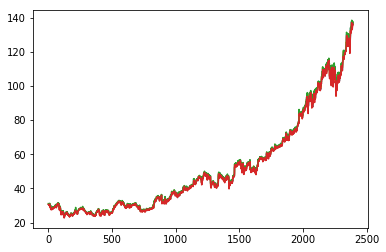

In [4]:
plt.figure()
plt.plot(msft["Open"])
plt.plot(msft["Close"])
plt.plot(msft["High"])
plt.plot(msft["Low"])
plt.show()

### Normalize Data

Normlaizing the data simply helps the algorithm in converging i.e. to find local/ global minimum efficiently, for future predictions. Before fully normalizing the data, we also split the dataset into training and testing data sets. As expected, the training dataset is used to train the model, and the testing dataset is used to observe the performance of the model after the training.


In [5]:
df_train, df_test = train_test_split(msft, train_size=0.86, test_size=0.14, shuffle=False)

In [6]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


In [7]:
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2057,2018-03-07,93.16,93.94,92.43,93.86,91.96,26716100
2058,2018-03-08,94.27,95.10,93.77,94.43,92.52,25887800
2059,2018-03-09,95.29,96.54,95.00,96.54,94.59,36937300
2060,2018-03-12,96.50,97.21,96.04,96.77,94.81,26073700
2061,2018-03-13,97.00,97.24,93.97,94.41,92.50,35387800


In [8]:
def train_and_test(data, stock_name="", load_model=False):
    df_train, df_test = train_test_split(data, train_size=0.84, test_size=0.16, shuffle=False)
    
    train_cols = ["Open", "High", "Low", "Adj Close", "Volume"]
    print("Train and Test Size:", len(df_train), len(df_test))
    x = df_train.loc[:,train_cols].values
    min_max_scaler = MinMaxScaler()
    
    # Transforming Data
    x_train = min_max_scaler.fit_transform(x)
    x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
    print(df_train[train_cols])

    

    def build_timeseries(mat, y_col_index):
        # y_col_index is the index of column that would act as output column
        # total number of time-series samples would be len(mat) - TIME_STEPS
        dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
        x = np.zeros((dim_0, TIME_STEPS, dim_1))
        y = np.zeros((dim_0,))
        for i in range(dim_0):
            x[i] = mat[i:TIME_STEPS+i]
            y[i] = mat[TIME_STEPS+i, y_col_index]
        print("length of time-series i/o",x.shape,y.shape)
        return x, y

    def trim_dataset(mat, batch_size):
        """
        trims dataset to a size that's divisible by BATCH_SIZE
        """
        no_of_rows_drop = mat.shape[0]%batch_size
        if(no_of_rows_drop > 0):
            return mat[:-no_of_rows_drop]
        else:
            return mat

    x_t, y_t = build_timeseries(x_train, 3)
    x_t = trim_dataset(x_t, BATCH_SIZE)
    y_t = trim_dataset(y_t, BATCH_SIZE)
    x_temp, y_temp = build_timeseries(x_test, 3)
    x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
    y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
    # print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(40,activation='relu')) # 40
    lstm_model.add(Dense(1,activation='sigmoid')) # 
    optimizer = optimizers.RMSprop(lr=0.001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    csv_logger = CSVLogger("stock_supervised.log", append=True)

    history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE, #50
                            shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                            trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
    
    lstm_model.save("SL_stock_model.h5")
    
    from keras.models import load_model

    y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
    y_pred = y_pred.flatten()
    y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
    error = mean_squared_error(y_test_t, y_pred)
    #print("Error is", error, y_pred.shape, y_test_t.shape)

    # convert the predicted value to range of real data
    y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_pred)
    y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_test_t_org)
    plt.title('Prediction vs Real Stock Price ' + stock_name)
    plt.ylabel('Price')
    plt.xlabel('Days')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.savefig('pred_vs_real_BS_'+stock_name+'.png')

    plt.show()

    return y_test_t_org, y_pred_org

In [9]:
x_train.shape, x_test.shape


NameError: name 'x_train' is not defined

## Build Time-Series Structure

One of the most improtant aspects of creating an effective model is the actual algorithm we use. Here, we are using an LSTM model specifically for its well-suitment to process and predict time series given values that change over an unkown period of time. 

LSTMs consume input in format of a three-dimensional array; [ batch_size, time_steps, Features ]

Batch Size is a number representing the number of samples of data the nueral net should see before re-adjusting and updating weights. 

The Time Steps basically define how many units back in time you want your network to see.


Features is the number of attributes used to represent each time step.

We label these parameters in the initializtion of the project.








In [ ]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [ ]:
csv_logger = CSVLogger("stock_supervised.log", append=True)

history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE, #50
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
lstm_model.save("SL_stock_model.h5")

In [ ]:
from keras.models import load_model

y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

print(y_pred_org[0:15])
print(y_test_t_org[0:15])

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.savefig('pred_vs_real_BS_.png')


In [ ]:
from keras import backend as K

def coeff_determination(y_true, y_pred):

    SS_res =K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

R_2 = coeff_determination(y_test_t_org, y_pred_org)
with tf.Session() as sess:  
    print(R_2.eval()) 


In [10]:
def calc_profits(y, y_pred, stock):
    positions = [y[0]]
    profits = []
    max_len_p = 0
    #eps = 0.02 # Vary this between 0.01 and 0.05 to maximize profit
    epsilons = np.arange(0, 0.01, .0001)
    max_pos = []
    for eps in epsilons:
        profit= 0
        for t in range(1,len(y)):
            if y_pred[t] > y_pred[t-1] + eps*y_pred[t-1]:
                positions.append(y[t])
            elif y_pred[t] < y_pred[t-1] - eps*y_pred[t-1]:
                for p in positions:
                    profit += (y[t] - p)
                positions = []
            max_len_p = max(max_len_p, len(positions))
        profits.append(profit)
        max_pos.append(max_len_p)

    plt.figure()
    plt.plot(epsilons, profits)
    plt.title('Profit maximization ' + stock)
    plt.ylabel('Profits')
    plt.xlabel('Epsilon')
    plt.legend(['Profits', 'Epsilon'], loc='upper left')
    plt.show()
    print("Max Profits:", max(profits))
    return max(profits)

If we change the epsilon value, we essentially change the range we can choose whether or not to buy or sell at, rather than hold. From these results, we can see that our maximum epsilon value is around 0.02, so we buy a stock when our predicted price is more than 2% higher than what it was the day before, and we sell if our maximum epsilon value is around 2% lower.  

Train and Test Size: 2009 383
       Open   High    Low  Adj Close     Volume
0     30.62  31.10  30.59      24.53   38409100
1     30.85  31.10  30.64      24.53   49749600
2     30.88  31.08  30.52      24.38   58182400
3     30.63  30.70  30.19      24.13   50559700
4     30.28  30.88  30.24      24.30   51197400
5     30.71  30.76  30.12      23.99   68754700
6     30.15  30.40  29.91      23.83   65912100
7     30.26  30.52  30.01      24.05   51863500
8     30.31  31.10  30.26      24.53   63228100
9     31.08  31.24  30.71      24.45   79913200
10    30.75  31.24  30.68      24.64   46575700
11    30.81  30.94  30.31      24.24   54849500
12    30.61  30.72  30.00      23.78   73086700
13    30.00  30.20  28.84      22.95  102004600
14    29.24  29.66  29.10      23.23   63373000
15    29.20  29.85  29.09      23.38   66639900
16    29.35  29.82  29.02      23.51   63949500
17    29.84  29.87  28.89      23.11  117513700
18    29.90  29.92  27.66      22.33  193888500
19    28.3

W1208 16:53:36.964216 66352 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1208 16:53:36.982161 66352 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1208 16:53:36.986168 66352 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1208 16:53:37.199578 66352 deprecation_wrapper.py:119] From C:\Users\adebi\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1208 16:53:37.206588 66352 deprecation.py:506

Train on 1950 samples, validate on 150 samples
Epoch 1/50
 - 2s - loss: 0.0145 - val_loss: 0.0866
Epoch 2/50
 - 1s - loss: 0.0241 - val_loss: 0.0792
Epoch 3/50
 - 1s - loss: 0.0146 - val_loss: 0.0736
Epoch 4/50
 - 1s - loss: 0.0098 - val_loss: 0.0643
Epoch 5/50
 - 1s - loss: 0.0057 - val_loss: 0.0702
Epoch 6/50
 - 1s - loss: 0.0042 - val_loss: 0.0751
Epoch 7/50
 - 1s - loss: 0.0035 - val_loss: 0.0618
Epoch 8/50
 - 1s - loss: 0.0034 - val_loss: 0.0773
Epoch 9/50
 - 1s - loss: 0.0030 - val_loss: 0.0626
Epoch 10/50
 - 1s - loss: 0.0027 - val_loss: 0.0560
Epoch 11/50
 - 1s - loss: 0.0025 - val_loss: 0.0548
Epoch 12/50
 - 1s - loss: 0.0026 - val_loss: 0.0556
Epoch 13/50
 - 1s - loss: 0.0024 - val_loss: 0.0590
Epoch 14/50
 - 1s - loss: 0.0025 - val_loss: 0.0633
Epoch 15/50
 - 1s - loss: 0.0026 - val_loss: 0.0694
Epoch 16/50
 - 1s - loss: 0.0022 - val_loss: 0.0646
Epoch 17/50
 - 1s - loss: 0.0022 - val_loss: 0.0748
Epoch 18/50
 - 1s - loss: 0.0019 - val_loss: 0.0650
Epoch 19/50
 - 1s - loss: 

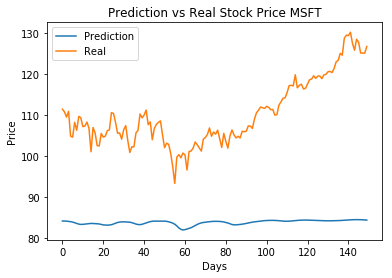

Train and Test Size: 2009 383
         Open     High      Low  Adj Close    Volume
0      313.79   315.07   312.43     313.69   3908400
1      313.90   314.23   311.08     312.31   6003300
2      313.24   313.24   303.48     304.43   7949400
3      305.01   305.31   296.62     297.35  12815700
4      296.30   301.93   294.85     301.31   9439100
5      302.53   302.53   297.32     300.86  14411300
6      299.12   299.38   294.29     295.54   9696800
7      288.53   294.48   287.24     293.84  12980200
8      292.24   297.40   291.70     295.22   8471700
9      296.97   297.08   289.31     290.29  10858100
10     290.89   295.51   288.43     294.10   8624700
11     293.28   293.28   287.93     290.50   6494800
12     292.01   293.70   286.41     291.78  12602700
13     282.53   285.59   267.70     275.28  13587100
14     273.57   275.22   268.02     270.27   8830900
15     269.25   275.08   268.41     271.48   8702200
16     270.91   274.10   267.92     271.32   7920800
17     272.52   

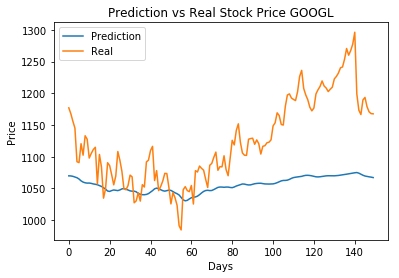

Train and Test Size: 2009 383
         Open     High      Low  Adj Close    Volume
0      136.25   136.61   133.14     133.90   7599900
1      133.43   135.48   131.81     134.69   8851900
2      134.60   134.73   131.65     132.25   7178800
3      132.01   132.32   128.80     130.00  11030200
4      130.56   133.68   129.03     133.52   9830500
5      132.62   132.80   129.21     130.31   8779400
6      128.99   129.82   126.55     127.35   9096300
7      127.90   129.71   125.75     129.11  10723200
8      129.14   130.38   126.40     127.35   9774900
9      129.18   129.65   127.06     127.14  15376500
10     126.31   128.00   124.33     127.61   8892600
11     127.13   129.20   125.08     125.78   9074700
12     127.26   128.15   125.00     126.62   9970600
13     125.60   127.67   120.76     121.43  11568900
14     122.10   122.28   118.12     120.31  12023900
15     120.56   122.98   119.06     119.48   9559000
16     121.03   123.33   118.80     122.75  14765300
17     124.43   

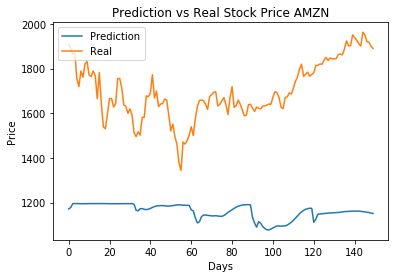

Train and Test Size: 2009 383
        Open    High     Low  Adj Close    Volume
0     131.18  132.97  130.85      99.30   6155300
1     131.68  131.85  130.10      98.10   6841400
2     130.68  131.49  129.81      97.46   5605300
3     129.87  130.25  128.91      97.13   5840600
4     129.07  130.92  129.05      98.10   4197200
5     131.06  131.06  128.67      97.07   5730400
6     129.03  131.33  129.00      97.84   8081500
7     130.39  131.12  129.16      97.63   6455400
8     130.55  132.71  129.91      99.19   7111800
9     132.03  132.89  131.09      98.80   8494400
10    131.63  134.25  131.56     100.57  13916200
11    130.46  131.15  128.95      97.65  15197500
12    130.47  130.69  128.06      96.71   9608600
13    128.67  128.89  125.37      94.09  10088600
14    126.33  126.89  125.71      94.55   5738500
15    125.92  127.75  125.41      94.28   7135300
16    125.82  126.96  125.04      94.71   8719200
17    127.03  127.04  123.05      92.78   9622200
18    124.32  125.00

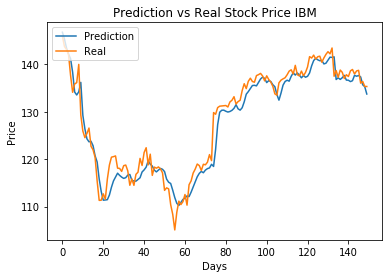

Train and Test Size: 2009 383
        Open    High     Low  Adj Close     Volume
0      30.49   30.64   30.34      26.78  123432400
1      30.66   30.80   30.46      26.83  150476200
2      30.63   30.75   30.11      26.40  138040000
3      30.25   30.29   29.86      26.35  119282800
4      30.04   30.29   29.87      26.53  111902700
5      30.40   30.43   29.78      26.29  115557400
6      29.88   29.97   29.49      26.00  148614900
7      29.70   30.13   29.16      26.36  151473000
8      30.02   30.07   29.86      26.21  108223500
9      30.13   30.23   29.41      25.77  148516900
10     29.76   30.74   29.61      26.91  182501900
11     30.70   30.79   29.93      26.50  153038200
12     30.30   30.47   29.60      26.04  152038600
13     29.54   29.64   28.17      24.75  220441900
14     28.93   29.24   28.60      25.41  266424900
15     29.42   30.53   28.94      25.77  466777500
16     29.55   30.08   28.50      26.02  430642100
17     29.28   29.36   28.39      24.94  293375600
1

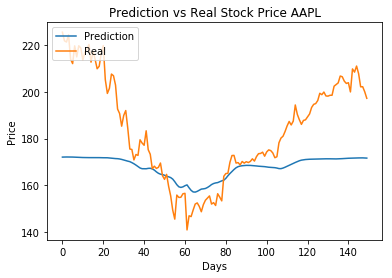

In [11]:
msft_y, msft_y_pred = train_and_test(msft, "MSFT")
googl_y, googl_y_pred = train_and_test(googl, "GOOGL")
amzn_y, amzn_y_pred = train_and_test(amzn, "AMZN")
ibm_y, ibm_y_pred = train_and_test(ibm, "IBM")
aapl_y, aapl_y_pred = train_and_test(aapl, "AAPL")

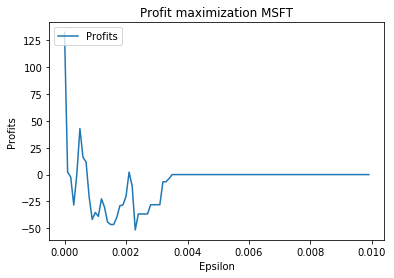

Max Profits: 132.5200000000002


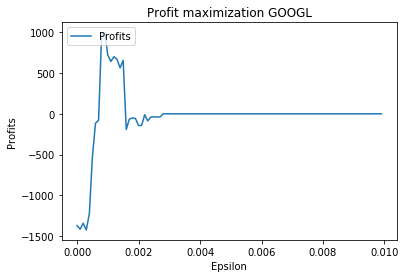

Max Profits: 1000.2700000000016


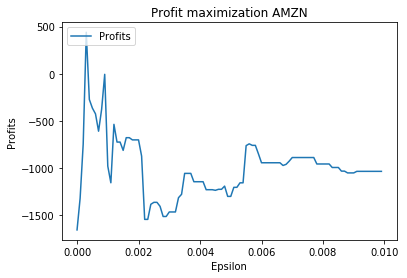

Max Profits: 440.619999999994


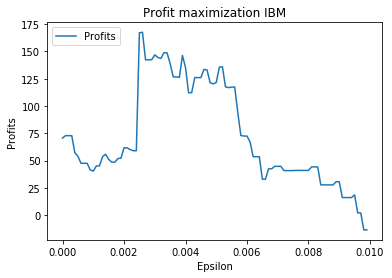

Max Profits: 167.54999999999995


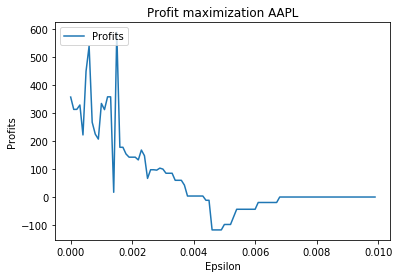

Max Profits: 588.6800000000003


In [12]:
msft_profits = calc_profits(msft_y, msft_y_pred, "MSFT")
googl_profits = calc_profits(googl_y, googl_y_pred, "GOOGL")
amzn_profits = calc_profits(amzn_y, amzn_y_pred, "AMZN")
ibm_profits = calc_profits(ibm_y, ibm_y_pred, "IBM")
aapl_profits = calc_profits(aapl_y, aapl_y_pred, "AAPL")